In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
from tqdm.notebook import tqdm
import random
import time
import matplotlib.pyplot as plt
np.random.seed(0)

In [3]:
def sech2(x):
    return (2/(np.exp(x)+np.exp(-x)))**2

In [4]:
def sig(x):
    return 1/(1+np.exp(-x))

In [5]:
def sigdash(x):
    return sig(x)*(1-sig(x))

In [6]:
X_train = []
X_val = []
X_test = []
y_train = np.zeros(5000)
y_val = np.zeros(1000)
y_test = np.zeros(1000)

In [7]:
#DataSet Creation 
for i in range(7000):
    size = random.randint(1,10)
    data = np.random.random((size,2))
    pos2 = np.zeros(size)
    pos = np.random.randint(size,size=2)
    pos2[pos]=1
    data[:,1] = pos2
    if i<5000:
        X_train.append(data)
        y_train[i] = np.sum(data[[pos],0])
    elif i>=5000 and i<6000:
        X_val.append(data)
        y_val[i-5000] = np.sum(data[[pos],0])
    else:
        X_test.append(data)
        y_test[i-6000] = np.sum(data[[pos],0])

# Elman RNN

In [90]:
#RNN Model
class RNN:
    def __init__(self):
        super(RNN, self).__init__()  
        self.U = np.random.random((1,X_train[0].shape[1]))
        self.V = np.random.random(1)
        self.W = np.random.random(1)
        self.bh = np.random.random(1)
        self.by = np.random.random(1)
        self.df = []
    
    def FP(self,x):
        h = np.zeros(x.shape[0]+1)
        for i in range(x.shape[0]):
            innerval = (self.U@x[i,:].T) + (self.W*h[i]) + self.bh
            h[i+1] = np.tanh(innerval)
        return self.V*h[-1] + self.by
    
    def predict(self,X_testset):
        output = np.zeros(len(X_testset))
        for i in range(output.shape[0]):
            output[i] = self.FP(X_testset[i])
        return output    
    
    def MSE(self,X_testset,y_testset):
        return np.mean((y_testset-self.predict(X_testset))**2)
    
        
    def train(self,X_train,y_train,epochs=None,lr=None):
        if epochs is None:
            epochs = 10
        if lr is None:
            lr=0.001  
         
        for epoch in tqdm(range(epochs)):
            
            for j in range(y_train.shape[0]):

                h = np.zeros(X_train[j].shape[0]+1)
                X = X_train[j]

                #H[0,1,2.....n] : size = n+1
                #dhj/dhj-1 = [0]dh1/dh0, [1]dh2/dh1........dhn/dhn-1 : size = n
                #dhj/dW = [0]dh1/dW, [1]dh2/dW......dhn/dW : size = n
                dhjdW = np.zeros(X.shape[0])
                dhjdhj_1 = np.zeros(X.shape[0])
                dhjdU = np.zeros((X.shape[0],2))
                dhjdbh = np.zeros(X.shape[0])
                
                for i in range(X.shape[0]):
                    innerval = (self.U@X[i,:].T) + (self.W*h[i]) + self.bh
                    h[i+1] = np.tanh(innerval)
                    secant = sech2(innerval)
                    dhjdhj_1[i] =  secant * self.W 
                    dhjdW[i] = secant * h[i]
                    dhjdU[i] = secant * X[i,:].T
                    dhjdbh[i] = secant

                    
                yp = (self.V*h[-1]) + self.by


                dLdV = -2*(y_train[j]-yp)*h[-1]   
                dLdhn = -2*self.V*(y_train[j]-yp)
                dLdby = -2*(y_train[j]-yp)

                
                product = np.zeros(X.shape[0])
                product[:-1] = np.cumprod(dhjdhj_1[1:][::-1])[::-1]
                dLdW = np.sum(dLdhn * product * dhjdW)
                dLdU = np.sum(dLdhn * np.dstack([product]*2) * dhjdU) 
                dLdbh = np.sum(dLdhn * product * dhjdbh)
                
                
                self.U -= lr*dLdU    
                self.V -= lr*dLdV
                self.W -= lr*dLdW
                self.by -= lr*dLdby
                self.bh -= lr*dLdbh
            self.df.append([epoch,self.MSE(X_train,y_train)])

In [96]:
model = RNN()

In [97]:
model.MSE(X_val,y_val)

0.3111325378651809

In [98]:
model.train(X_train,y_train,epochs=100,lr=1e-2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [99]:
model.MSE(X_val,y_val)

0.2144762511365601

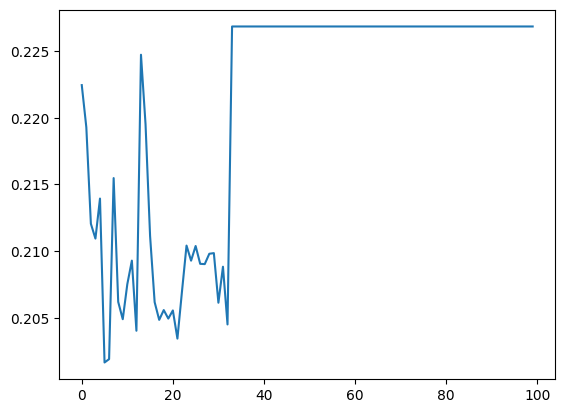

In [100]:
benchmark = model.df
benchmark = np.array(benchmark)
plt.plot(benchmark[:,0],benchmark[:,1])

# LSTM

## Calculating $\frac{\partial L}{\partial W}$
$
\begin{align}
h_t &= o_t \odot \sigma(S_t)\\
S_t &= f_t\odot S_{t-1} + i_t \odot \tilde{S_t}\\
\frac{\partial h_t}{\partial S_t} &= o_t \odot \sigma'(S_t)\\
\frac{\partial h_t}{\partial h_{t-1}} &= W_o\sigma'(W_oh_{t-1}+U_o x_t +b_o) \odot \sigma(S_t) + \sigma(W_oh_{t-1}+U_o x_t +b_o) \odot \sigma'(S_t)\cdot \frac{\partial S_t}{\partial h_{t-1}}
\end{align}
$

$
\begin{align}
\frac{\partial S_t}{\partial h_{t-1}} &= W_f \sigma'(W_fh_{t-1}+U_f x_t +b_f)\odot S_{t-1} + W_i\sigma'(W_ih_{t-1}+U_i x_t +b_i) \odot \sigma(Wh_{t-1}+U x_t +b) + \sigma(W_ih_{t-1}+U_i x_t +b_i)\odot W\sigma'(Wh_{t-1}+U x_t +b)
\end{align}
$

$
\begin{align}
\frac{\partial S_t}{\partial S_{t-1}} &= \frac{\partial f_t}{\partial S_{t-1}} \odot S_{t-1} + f_t + \frac{\partial i_t}{\partial S_{t-1}} \odot \tilde{S_{t}} + i_t \odot \frac{\partial \tilde{S_t}}{\partial S_{t-1}} \\
\frac{\partial f_t}{\partial S_{t-1}} &= f_t' \cdot W_f \cdot \frac{\partial h_{t-1}}{\partial S_{t-1}}
\end{align}
$

But we know that $\frac{\partial h_t}{\partial S_t} = o_t \odot \sigma'(S_t)$. So,

$
\begin{align}
\frac{\partial f_t}{\partial S_{t-1}} &= f_t' \cdot W_f \cdot o_{t-1} \odot \sigma'(S_{t-1})
\end{align}
$
Parallely,
$
\begin{align}
\frac{\partial i_t}{\partial S_{t-1}} &= i_t' \cdot W_i\cdot o_{t-1} \odot \sigma'(S_{t-1})\\
\frac{\partial \tilde{S_t}}{\partial S_{t-1}} &= \tilde{S_t}' \cdot W\cdot o_{t-1} \odot \sigma'(S_{t-1})
\end{align}
$

$
\begin{align}
\therefore \frac{\partial S_t}{\partial S_{t-1}} &= f_t' \cdot W_f \cdot o_{t-1} \odot \sigma'(S_{t-1}) \odot S_{t-1} + f_t + i_t' \cdot W_i\cdot o_{t-1} \odot \sigma'(S_{t-1})\odot \tilde{S_{t}} + i_t \odot \tilde{S_t}' \cdot W\cdot o_{t-1} \odot \sigma'(S_{t-1})
\end{align}
$

## Selective Write/ Output gate

$
\begin{align}
\frac{\partial h_t}{\partial o_t} &= \sigma(S_t) \\
\frac{\partial h_t}{\partial W_o} &= \frac{\partial h_t}{\partial o_t} \cdot \frac{\partial o_t}{\partial W_o} = \sigma(S_t) \cdot h_{t-1}\sigma'(W_oh_{t-1}+U_o x_t +b_o)\\
\frac{\partial h_t}{\partial U_o} &= \frac{\partial h_t}{\partial o_t} \cdot \frac{\partial o_t}{\partial U_o} = \sigma(S_t) \cdot x_t\sigma'(W_oh_{t-1}+U_o x_t +b_o)\\
\frac{\partial h_t}{\partial b_o} &= \frac{\partial h_t}{\partial o_t} \cdot \frac{\partial o_t}{\partial b_o} = \sigma(S_t) \cdot \sigma'(W_oh_{t-1}+U_o x_t +b_o)
\end{align}
$

## Selective Read/ Input gate

$
\begin{align}
\frac{\partial h_t}{\partial i_t} &=  \frac{\partial h_t}{\partial S_t} \cdot \frac{\partial S_t}{\partial i_t} = o_t \odot \sigma'(S_t) \cdot \tilde{S_t}\\
\frac{\partial h_t}{\partial W_i} &= \frac{\partial h_t}{\partial i_t} \cdot \frac{\partial i_t}{\partial W_i} = o_t \odot \sigma'(S_t) \cdot \tilde{S_t} \cdot h_{t-1}\sigma'(W_ih_{t-1}+U_i x_t +b_i)\\
\frac{\partial h_t}{\partial U_i} &= \frac{\partial h_t}{\partial i_t} \cdot \frac{\partial i_t}{\partial U_i} = o_t \odot \sigma'(S_t) \cdot \tilde{S_t} \cdot x_t\sigma'(W_ih_{t-1}+U_i x_t +b_i)\\
\frac{\partial h_t}{\partial b_i} &= \frac{\partial h_t}{\partial i_t} \cdot \frac{\partial i_t}{\partial b_i} = o_t \odot \sigma'(S_t) \cdot \tilde{S_t} \cdot \sigma'(W_ih_{t-1}+U_i x_t +b_i)
\end{align}
$

## Selective Forget/ Forget gate

$
\begin{align}
\frac{\partial h_t}{\partial f_t} &= \frac{\partial h_t}{\partial S_t} \cdot \frac{\partial S_t}{\partial f_t}= o_t \odot \sigma'(S_t) \cdot S_{t-1} \\
\frac{\partial h_t}{\partial W_f} &= \frac{\partial h_t}{\partial f_t} \cdot \frac{\partial f_t}{\partial W_f} = o_t \odot \sigma'(S_t) \cdot S_{t-1} \cdot h_{t-1}\sigma'(W_fh_{t-1}+U_f x_t +b_f)\\
\frac{\partial h_t}{\partial U_f} &= \frac{\partial h_t}{\partial f_t} \cdot \frac{\partial f_t}{\partial U_f} = o_t \odot \sigma'(S_t) \cdot S_{t-1} \cdot x_t\sigma'(W_fh_{t-1}+U_f x_t +b_f)\\
\frac{\partial h_t}{\partial b_f} &= \frac{\partial h_t}{\partial f_t} \cdot \frac{\partial f_t}{\partial b_f} = o_t \odot \sigma'(S_t) \cdot S_{t-1} \cdot \sigma'(W_fh_{t-1}+U_f x_t +b_f)
\end{align}
$

### Using the same equations of RNN for LSTM,

$
\begin{align}
\frac{\partial L}{\partial W} &=  \sum_{k=2}^{n}\frac{\partial L}{\partial h_k}\frac{\partial h_k} {\partial S_{k}} \left( \prod_{j=3}^{k} \frac{\partial S_j} {\partial S_{j-1}} \right)\frac{\partial S_2}{\partial W}\\
&= \sum_{k=2}^{n}\frac{\partial L}{\partial h_n}\frac{\partial h_n} {\partial h_{k}}\frac{\partial h_k} {\partial S_{k}} \left( \prod_{j=3}^{k} \frac{\partial S_j} {\partial S_{j-1}} \right)\frac{\partial S_2}{\partial W}\\
\frac{\partial L}{\partial h_n} &= -2(y-h_n)\\
\frac{\partial h_n}{\partial h_k} &= \prod_{j=k+1}^n \frac{\partial h_j}{\partial h_{j-1}}\\
\frac{\partial S_2}{\partial W} &= i_2 \odot \tilde{S_2'}\cdot h_1
\end{align}
$

### Now, we have everything to calculate $\frac{\partial L}{\partial W}$

# Using the same equation for $\frac{\partial L}{\partial b}$ which we used for $ \frac{\partial L}{\partial W}$ 

$
\begin{align}
\frac{\partial L}{\partial b} &=  \sum_{k=2}^{n}\frac{\partial L}{\partial h_k}\frac{\partial h_k} {\partial S_{k}} \left( \prod_{j=2}^{k} \frac{\partial S_j} {\partial S_{j-1}} \right)\frac{\partial S_1}{\partial b}\\
&= \sum_{k=2}^{n}\frac{\partial L}{\partial h_n}\frac{\partial h_n} {\partial h_{k}}\frac{\partial h_k} {\partial S_{k}} \left( \prod_{j=2}^{k} \frac{\partial S_j} {\partial S_{j-1}} \right)\frac{\partial S_1}{\partial b}\\
\frac{\partial S_1}{\partial b} &= i_1 \odot \tilde{S_1'}
\end{align}
$

# Using the same equation for $\frac{\partial L}{\partial U}$ which we used for $ \frac{\partial L}{\partial W}$ 

$
\begin{align}
\frac{\partial L}{\partial U} &=  \sum_{k=2}^{n}\frac{\partial L}{\partial h_k}\frac{\partial h_k} {\partial S_{k}} \left( \prod_{j=2}^{k} \frac{\partial S_j} {\partial S_{j-1}} \right)\frac{\partial S_1}{\partial U}\\
&= \sum_{k=2}^{n}\frac{\partial L}{\partial h_n}\frac{\partial h_n} {\partial h_{k}}\frac{\partial h_k} {\partial S_{k}} \left( \prod_{j=2}^{k} \frac{\partial S_j} {\partial S_{j-1}} \right)\frac{\partial S_1}{\partial U}\\
\frac{\partial S_1}{\partial U} &= i_1 \odot \tilde{S_1'} \cdot x_1
\end{align}
$

In [235]:
#LSTM Model
class LSTM():
    def __init__(self):
        self.W = np.random.random(1)
        self.Wo = np.random.random(1)
        self.Wi = np.random.random(1)
        self.Wf = np.random.random(1)
        self.U = np.random.random((1,X_train[0].shape[1]))
        self.Uo = np.random.random((1,X_train[0].shape[1]))
        self.Ui = np.random.random((1,X_train[0].shape[1]))
        self.Uf = np.random.random((1,X_train[0].shape[1]))
        self.b = np.random.random(1)
        self.bo = np.random.random(1)
        self.bi = np.random.random(1)
        self.bf = np.random.random(1)
        self.df = []
        
    def _FP(self,x) :
        h = np.zeros(x.shape[0]+1)
        #st = [0]s0,[1]s1,[2]s2,.....[n]sn
        st = np.zeros(x.shape[0]+1)
        for i in range(x.shape[0]):
            #ot = [0]o1,[1]o2.....on
            #h = [0]h0,[1]h1...[n+1]hn
            #x = [0]x1,[1]x2....[n-1]xn
            #Gates
            ot = sig((self.Wo*h[i]) + (self.Uo@x[i,:].T) + self.bo)
            ft = sig((self.Wf*h[i]) + (self.Uf@x[i,:].T) + self.bf)
            it = sig((self.Wi*h[i]) + (self.Ui@x[i,:].T) + self.bi)    
            
            
            #States
            stTilda = sig((self.W*h[i]) + (self.U@x[i,:].T) + self.b)
            st[i+1] = (ft * st[i]) + (it * stTilda)
            h[i+1] = ot * sig(st[i+1])
        return h,st
        
        
    def FP(self,x):        
        h,_ = self._FP(x)
        return h[-1]
        
    def predict(self,X_testset):
        output = np.zeros(len(X_testset))
        for i in range(output.shape[0]):
            output[i] = self.FP(X_testset[i])
        return output    
    
    
    def MSE(self,X_testset,y_testset):
        return np.mean((y_testset-self.predict(X_testset))**2)
    
    def train(self,X_train,y_train,epochs=None,lr=None):
        if epochs is None:
            epochs = 10
        if lr is None:
            lr=20 
         
        for epoch in tqdm(range(epochs)):
            
            # z => zth datapoint
            for z in range(y_train.shape[0]):
                
                h,st = self._FP(X_train[z])
                
                x = X_train[z]
                
                #dStdht_1 => dS1/dh0 , dS2/dh1 .....
                  
    
                dStdht_1 = st[:-1] * self.Wf * sigdash((self.Wf*h[:-1]) + (self.Uf@x.T) + self.bf) \
                            + \
                            (self.Wi*sig((self.W*h[:-1]) + (self.U@x.T) + \
                            self.b)*sigdash((self.Wi*h[:-1]) + (self.Ui@x.T) + self.bi))\
                            + \
                            self.W*sig((self.Wi*h[:-1]) + (self.Ui@x.T) + self.bi) *\
                            sigdash((self.W*h[:-1]) + (self.U@x.T) + self.b)
        


               # dhtdht_1 => dh1/dh0, dh2dh1 ....dhn/dhn-1

                dhtdht_1 = self.Wo*sigdash((self.Wo*h[:-1]) + (self.Uo@x.T) + self.bo)*sig(st[1:])\
                           + \
                           sig((self.Wo*h[:-1]) + (self.Uo@x.T) + self.bo)*sigdash(st[1:])*dStdht_1
                    
                dhtdht_1 = dhtdht_1.T

                
                
                dLdh_n = -2*(y_train[z]-h[-1])    
                
                

                dh_ndh_k = np.ones(x.shape[0])
                dh_ndh_k[1:] = np.cumprod(dhtdht_1[1:][::-1])
                dh_ndh_k = dh_ndh_k[::-1]
                
                
                
                dh_kdS_k = sig((self.Wo*h[:-1]) + (self.Uo@x.T) + self.bo) * sigdash(st[1:])
                dh_kdS_k = np.squeeze(dh_kdS_k)
                
                
                
                dS_jdSj_1 = np.zeros(x.shape[0])
                # dS_jdSj_1 => dS1/dS0 , dS2/dS1....
                for i in range(x.shape[0]):
                    dS_jdSj_1[i] = sigdash((self.Wf*h[i]) + (self.Uf@x[i,:].T) + self.bf) * self.Wf \
                                    * sig((self.Wo*h[i-1]) + (self.Uo@x[i-1,:].T) + self.bo) * \
                                    sigdash(st[i]) * st[i] \
                                    + \
                                    sig((self.Wf*h[i]) + (self.Uf@x[i,:].T) + self.bf)\
                                    + \
                                    sigdash((self.Wi*h[i]) + (self.Ui@x[i,:].T) + self.bi) * self.Wi \
                                    * sig((self.Wo*h[i-1]) + (self.Uo@x[i-1,:].T) + self.bo) * \
                                    sigdash(st[i]) * sig((self.W*h[i]) + (self.U@x[i,:].T) + self.b)\
                                    + \
                                    sig((self.Wi*h[i]) + (self.Ui@x[i,:].T) + self.bi) *\
                                    sigdash((self.W*h[i]) + (self.U@x[i,:].T) + self.b) * self.W *\
                                    sig((self.Wo*h[i-1]) + (self.Uo@x[i-1,:].T) + self.bo) *sigdash(st[i]) 
                    
                
                
                dS2dW = sig((self.Wi*h[1]) + (self.Ui@x[0,:].T) + self.bi) *\
                        sigdash((self.W*h[i]) + (self.U@x[i,:].T) + self.b) * h[1]
                dS1db = sig((self.Ui@x[0]) + self.bi) * sigdash((self.U@x[0])+self.b)
                dS1dU = sig((self.Ui@x[0]) + self.bi) * sigdash((self.U@x[0])+self.b) * x[0]
                
                
                
                try:
                    dLdW = np.sum(dLdh_n * dh_ndh_k[2:] * dh_kdS_k[2:] * np.cumprod(dS_jdSj_1[2:]) * dS2dW)
                except IndexError:
                    dLdW = 0
                    
                    
                product = np.cumprod(dS_jdSj_1[1:])
                
                
                try : 
                    initial = dLdh_n * dh_ndh_k[1:] * dh_kdS_k[1:]
                except IndexError:
                    initial = 0    
                
                
                dLdb = np.sum(initial * product * dS1db)
                product = np.squeeze(np.dstack([product]*2))
                dLdU = np.sum(np.dstack([initial]*2) * product * dS1dU,axis=1)
            
                             
                #Selective Write
                dhndo_n = sig(st[-1])
                do_t = sigdash((self.Wo*h[i-1]) + (self.Uo@x[i-1,:].T) + self.bo)
                dhndWo = dhndo_n * h[-2] * do_t
                dhndUo = dhndo_n * h[-1] * do_t
                dhndbo = dhndo_n * do_t
                
                dLdWo = dLdh_n * dhndWo
                dLdUo = dLdh_n * dhndUo
                dLdbo = dLdh_n * dhndbo
                
                
                #Selective Read
                dhndo_n = sig(st[-1])
                do_t = sigdash((self.Wo*h[i-1]) + (self.Uo@x[i-1,:].T) + self.bo)
                dhndWo = dhndo_n * h[-2] * do_t
                dhndUo = dhndo_n * h[-1] * do_t
                dhndbo = dhndo_n * do_t
                
                dLdWo = dLdh_n * dhndWo
                dLdUo = dLdh_n * dhndUo
                dLdbo = dLdh_n * dhndbo
                
                
                  
                self.W -= lr * dLdW
                self.U -= lr * dLdU
                self.b -= lr * dLdb
                self.Wo -= lr * dLdWo
                self.Uo -= lr * dLdUo
                self.bo -= lr * dLdbo
                
            self.df.append([epoch,self.MSE(X_train,y_train)])

In [236]:
model = LSTM()

In [237]:
model.train(X_train,y_train)

  0%|          | 0/10 [00:00<?, ?it/s]

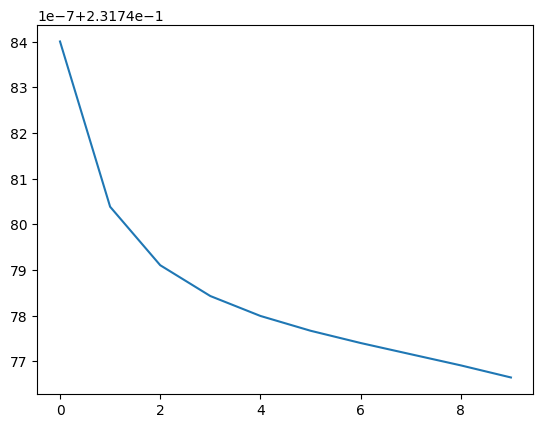

In [238]:
benchmark = model.df
benchmark = np.array(benchmark)
plt.plot(benchmark[:,0],benchmark[:,1])

# GRU

## Gates:
$
\begin{align}
o_t &= \sigma(W_o S_{t-1}+U_o x_t + b_o)\\
i_t &= \sigma(W_i S_{t-1}+U_i x_t + b_i)
\end{align}
$

## States:
$
\begin{align}
\tilde{S_t} &= \sigma(W(o_t \odot S_{t-1})+Ux_t+b)\\
S_t &= (1-i_t)\odot S_{t-1} + i_t \odot \tilde{S_t}
\end{align}
$

In [12]:
class GRU:
    def __init__(self):
        self.W = np.random.random(1)
        self.Wo = np.random.random(1)
        self.Wi = np.random.random(1)
        self.U = np.random.random((1,X_train[0].shape[1]))
        self.Uo = np.random.random((1,X_train[0].shape[1]))
        self.Ui = np.random.random((1,X_train[0].shape[1]))
        self.b = np.random.random(1)
        self.bo = np.random.random(1)
        self.bi = np.random.random(1)
        
    def _FP(self,x):
        S = np.zeros(x.shape[0])
        for t in range(x.shape[0]):
            ot = sig((self.Wo*S[t-1]) + (self.Uo@x[t,:].T) + self.bo)
            it = sig((self.Wi*S[t-1]) + (self.Ui@x[t,:].T) + self.bi)
            stilde = sig(self.W * (ot * S[t-1])+(self.U@x[t,:])+ self.b)
            S[t] = ((1-it)*S[t-1]) + (it*stilde)
        return S
    
    def FP(self,x):
        S = _FP(x)
        return S[-1]
    
    def predict(self,X_testset):
        output = np.zeros(len(X_testset))
        for i in range(output.shape[0]):
            output[i] = self.FP(X_testset[i])
        return output         
    
    def MSE(self,X_testset,y_testset):
        return np.mean((y_testset-self.predict(X_testset))**2)
    
    def train(self,X_train,y_train,epochs=None,lr=None):
        if epochs is None:
            epochs = 10
        if lr is None:
            lr=1e-2
            
        
        for epoch in tqdm(range(epochs)):
            
            
            for z in range(y_train.shape[0]):
                
                S = self._FP(X_train[z])
                h = np.zeros(S.shape[0]+1)
                h[1:] = S
                x = X_train[z]
                ot = sig((self.Wo*h[:-1]) + (self.Uo@x.T) + self.bo)
                it = sig((self.Wi*h[:-1]) + (self.Ui@x.T) + self.bi)
                
                dotdSt_1 = sigdash((self.Wo*h[:-1]) + (self.Uo@x.T) + self.bo)*self.Wo
                ditdSt_1 = sigdash((self.Wi*h[:-1]) + (self.Ui@x.T) + self.bi)*self.Wi
                
                
                dStildSt_1 = sigdash((self.W*(S*ot)) + (self.U@x.T) + self.b)*self.W*((dotdSt_1*h[:-1])+ot)
                dStdSt_1 = (1-it)-(h[:-1]*ditdSt_1)+ditdSt_1+(it*dStildSt_1)
                
                
                dLdSn = -2*(y_train[z]-S[-1])
                
                #dLdW = dLdSn * np.cumprod(dStdSt_1)
                try:
                    i2 = sig((self.Wi*S[0]) + (self.Ui@x[1,:].T) + self.bi)
                except IndexError:
                    i2 = sig((self.Wi*S[0])  + self.bi)
                    
                try:
                    dS2tildW = sigdash((self.W*(S[0]*ot[1])) + (self.U@x.T) + self.b) * (S[0]*ot[1])
                except IndexError:
                    dS2tildW = 0.0
                    
                dS2dW = i2 * dS2tildW
                 
                dLdW = np.sum(dLdSn * dS2dW * np.cumprod())

In [13]:
model = GRU()
model.train(X_train,y_train)

  0%|          | 0/10 [00:00<?, ?it/s]